## Automatic Piano Accomplishment

##### 1. Pitch tracking and bar marking

In [21]:
import math
import numpy as np
import IPython.display as ipd
import librosa
from matplotlib import pyplot as plt
import collections
from piano import *

In [247]:
# s, sr = librosa.load('tongnian_bpm150.m4a', sr=None)
# s_cut = s[int(sr*1.2):]
# sf.write('tongnian_bpm150.wav', s_cut, sr, subtype='PCM_24')

s, sr = librosa.load('Cant_help_falling_in_love_bpm150.m4a', sr=None)
s_cut = s[int(sr*0.8):]
# sf.write('Cant_help_falling_in_love_bpm90.wav', s_cut, sr, subtype='PCM_24')

# s, sr = librosa.load('amazing_grace_bpm90.m4a', sr=None)
# s_cut = s[int(sr*2.2):]
# sf.write('amazing_grace_bpm90.wav', s_cut, sr, subtype='PCM_24')

/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [248]:
ipd.Audio(s_cut, rate=sr)

In [249]:
frame_length = 2048
bpm =150
beats = 4
sec_per_m = 60/bpm*beats


In [250]:
sec_per_m

1.6

In [251]:
f0, voiced_flag, voiced_probs = librosa.pyin(s_cut, fmin=librosa.note_to_hz('C2'),\
                                             fmax=librosa.note_to_hz('A4'), sr = 44100,\
                                            frame_length=frame_length)

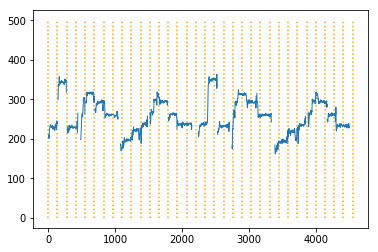

In [252]:
sample_per_m = sr*sec_per_m
num_measures = int(len(s_cut)//sample_per_m)
scalar_measure = [int(i*sample_per_m//(frame_length//4)) for i in range(num_measures+1)]

plt.vlines(scalar_measure, 0, 500, colors='orange', linestyles='dotted')
plt.plot(f0, label='f0', linewidth=1)

##### 2. Key detection

In [253]:
m_sample = sr*1.5
measures = int(len(s_cut)//m_sample)
notes_p_ms = []

for i in range(measures):
    s_low = int(m_sample*i)
    s_high = int(m_sample*(i+1))
    m_pitch = f0[int(s_low//(frame_length/4)): int(s_high//(frame_length/4))]
    m_pitch_valid = [m_pitch[i] for i in range(len(m_pitch)) if not math.isnan(m_pitch[i])]

    count = collections.Counter(librosa.hz_to_note(m_pitch_valid))
    notes_p_ms.append(count)


In [254]:
# Generate 3 octaves of major scale
def major_scale(base_midi): 
    steps = [0, 2, 4, 5, 7, 9, 11]
    return [base_midi+i for i in steps] + [base_midi+i-12 for i in steps] + [base_midi+i+12 for i in steps]

# Take most common midi note from every measure
common_midi = [librosa.note_to_midi(count.most_common(2)[0][0]) for count in notes_p_ms] 

# Assuming each note to be the basic note, save the percentage of other notes be fit in into the scale
key_prob = dict()
for idx, midi in enumerate(common_midi):
    scale = major_scale(midi)
    fit_in = 0
    for m in common_midi:
        if m in scale:
            fit_in += 1
    key_prob[midi] = key_prob.get(midi, 0)+ fit_in/len(common_midi)

# Take the midi with highest "fit-in percentage" as the basic midi of the key
key_midi = sorted(key_prob, key = lambda x: key_prob[x], reverse=True)[0]

# Shift amount from the original the melody to C4-centered scale
shift = 60 - key_midi

##### 3. Chord labeling

In [255]:
chords_p_ms = []

# chords
chords={'C' :{60: 9/26, 62:3/26, 64: 5/26, 67: 6/26, 69:3/26},\
        'Dm':{62: 2/7, 64:2/7, 65: 2/7, 67: 1/7},\
        'Em':{60:1/9, 67: 1/9, 69: 6/9, 71:1/9},\
        'F':{60: 3/11, 65: 2/11, 67:1/11, 69: 5/11},\
        'G':{64: 5/12, 67: 7/12},\
        'Am':{60: 5/11, 64: 5/11, 69: 1/11},\
        'Bm':{62:1/8, 67:1/2, 69:1/8, 71:2/8}
       }


# Calculate the posterier probability of each chords 
for notes in notes_p_ms: # take notes from every measure
    print('==notes==', librosa.note_to_midi(notes))
    posterier_chords = []
    total_occ = sum(notes.values())
    for chord, dist in chords.items():
        chord_prob = 0
        for note, times in notes.items():
            midi = librosa.note_to_midi(note)
            note_prob = times/total_occ
            chord_prob += max(dist.get(midi+shift, 0), dist.get(midi+12+shift, 0), \
                              dist.get(midi-12+shift, 0)) * note_prob
        posterier_chords.append((chord, chord_prob))
    
    chord_m = sorted(posterier_chords, key = lambda x: x[-1], reverse=True)[0]
    print(chord_m)
    chords_p_ms.append(chord_m)

==notes== [56 55 57 58 59]
('Am', 0.2950937950937951)
==notes== [59 58 62 63 64 65]
('G', 0.42097701149425293)
==notes== [65 64 63 58 57]
('Am', 0.2641802641802642)
==notes== [58 57 59 60 55 56]
('Am', 0.23197492163009406)
==notes== [60 61 62 63]
('Dm', 0.27594627594627597)
==notes== [63 62 61 60]
('Dm', 0.2564102564102564)
==notes== [62 61 60 59]
('Dm', 0.27611044417767105)
==notes== [60]
('Dm', 0.2857142857142857)
==notes== [60 59 54 53 52 55 56]
('Em', 0.27530864197530863)
==notes== [55 56 57 58]
('Em', 0.4675555555555555)
==notes== [57 56 55 58 54]
('Em', 0.15726495726495723)
==notes== [58 59 60 61]
('Am', 0.2597402597402597)
==notes== [60 61 62 63]
('Dm', 0.2812846068660022)
==notes== [62 59 60]
('Am', 0.40106951871657753)
==notes== [60 59 58 57]
('Dm', 0.2576112412177986)
==notes== [58 59]
('Am', 0.4405594405594405)
==notes== [58 57]
('Am', 0.44871794871794873)
==notes== [57 56 58 59]
('Am', 0.3614457831325301)
==notes== [58 59 60 61 62 63 64 65]
('G', 0.27325581395348836)
==note

##### 4. Accompaniment Generation

In [256]:
chords={'C' :[60-12, 64-12, 67-12, 60, 64, 67],\
        'Dm':[62-12, 65-12, 69-12, 62, 65, 69],\
        'Em':[64-12, 67-12, 71-12, 64, 67, 71],\
        'F':[65-12, 69-12, 60-12, 65, 69, 60],\
        'G':[67-12, 71-12, 62-12, 67, 71, 62],\
        'Am':[69-12, 60-12, 64-12, 69, 60, 64],\
        'Bm':[71-12, 62-12, 66-12, 71, 62, 66]
       }

melody1 = [[0],[2],[1],[2],[1],[2],[1],[2]]
melody2 = [[0, 2],[],[0, 2],[],[0, 1],[],[0, 2],[]]
melody3 = [[3,4,5], [4,5]]
melody4 = [[0,1,2], [1,2]]
melody5 = [[0,1,2]]
melody6 = [[0, 1],[0, 2],[1, 2],[0, 1]]
melody7 = [[0, 2],[1, 2],[0, 1]]

# melody1 = [[0],[2],[1],[2],[1],[2]]
# melody2 = [[0, 2],[],[0, 2],[],[0, 1],[],[0, 2],[]]
# melody3 = [[3,4,5], [4,5]]
# melody4 = [[0,1,2], [1,2]]
# melody5 = [[0,1,2]]
# melody6 = [[0, 2],[0, 2],[0, 1],[0, 2]]
# melody2 = []

def build_melody(length, melody, chord):
    bpm = 60/(sec_per_m/beats)
#     print(bpm)
    num = len(melody)
    time = length/len(melody)
    samples = int(time*sr)
    s = []
    f_list = chords[chord]
    pitch_input = []
    note_last = beats/num
    note_type = {0.5:8, 1:4, 2:2, 3:-2, 4:1}
    for i in range(len(melody)):
        note = np.zeros(samples)
        for n in melody[i]:
            midi = f_list[n]
            f = librosa.midi_to_note(midi-shift)
#             data = piano_wav([(f, type_note)], bpm=bpm)
#             print(len(data)/sr)
            f = f.replace('♯','#')
#             print(f)
            note += piano_wav([(f, note_type[note_last])], bpm=bpm)[:-(2*sr)]
        s.extend(note)

    return np.array(s)

# def sinf(f, time, rate=sr, bpm): # unit of t is sec
#     t_array = np.arange(0, time, 1/rate)
#     output = np.sin(2*math.pi*f*t_array)
#     return output


In [257]:
accom = []
for chord, _ in chords_p_ms:
    output=build_melody(sec_per_m, melody6, chord) # piano_wav
    accom.extend(output)
accom = np.array(accom)



In [259]:
length = int(min(len(accom), len(s_cut)//2.1))
m1 = max(abs(s_cut))
m2 = max(abs(accom))
ipd.Audio(accom[:length]/m2+s_cut[:length]/m1, rate=sr)
# import soundfile as sf
sf.write('cant_help_falling_in_love_bpm150_accom_1210_3.wav', accom[:length]/m2+s_cut[:length]/m1, sr, subtype='PCM_24')
# ipd.Audio(accom[:length]/m2, rate=sr)

In [111]:
s_cut

array([-0.00671387, -0.00637817, -0.00643921, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [97]:
from piano import *
data = piano_wav([('D#4', 4),('B3', 4),('B3', 4)], bpm=120)

[1/3]	


In [89]:
len(data[:-(2*sr)])/sr

1.5

In [98]:
import IPython.display as ipd
ipd.Audio(data[:-(2*sr)],rate = 44100)